# SIT326 Task P4

#### T1 2025 | Visal Dam, s223058093

In this task, I created a classification ML model (using a hypertuned **Random Forest Classifier**) to identify invalid certificates based on certificate metadata. This achievement revolved around two main steps, which is how this notebook file structured:
1) A python script was created to harvest certificates and extract relavent attributes from a list of domains. This is stored as a .csv file, and the dataset is manually balanced.
2) The .csv file is cleaned. A Random Forest Classifer is hypertuned and trained to classify certificates based on metadata. The model is judged based on the following metrics: accuracy score, precision-recall, and confusion matrices. These metrics are visualized. A plotted feature importance bar graph is also presented.

#### Results

|Metric|Score (%)|
|------|-------------------|
|Accuracy Score| 97.8%|
|Precision| 97.9%|
|Recall| 97.9%|
|ROC-AUC|97.3%|
|Precision-Recall AUC| 98.4%|


# Certificate Collection Script (.py)

### DO NOT RUN HERE!!!

In [ ]:
# DO NOT RUN HERE
import ssl
import socket
import datetime
from cryptography import x509
from cryptography.hazmat.primitives import hashes
from cryptography.x509.oid import ExtensionOID
import pandas as pd
from cryptography.hazmat.primitives.asymmetric import rsa, ec
import re
from time import sleep
import threading
from concurrent.futures import ThreadPoolExecutor

r = input("Run?") # DO NOT RUN HERE

port = 443
certData = {}
# if not in trusted -> bad 
trusted_issuers = ["DigiCert Inc", "GlobalSign nv-sa", "Sectigo Limited", "Apple Inc.", "Let's Encrypt", "Google Trust Services", "Amazon", "Microsoft Corporation"]
now = datetime.datetime.utcnow() # for checking expired

with open("new_sites.txt", "r") as f::
    sites = [line.strip() for line in f.readlines()]

def get_cert(site, port=443):
    context = ssl.create_default_context()
    context.check_hostname = False
    context.verify_mode = ssl.CERT_NONE  # accept all

    try:
        with socket.create_connection((site, port), timeout=60) as sock: # 10s sure?
            with context.wrap_socket(sock, server_hostname=site) as ssock:
                cert_der = ssock.getpeercert(binary_form=True)
                return x509.load_der_x509_certificate(cert_der)
    except Exception as e:
        print(f"Error cert for {site}: {e}")
        return None

def harvest(site, port):
    try:
        certOBJECT = get_cert(site, port)
        
        # subject of the cert, used as to identify certs
        subject = certOBJECT.subject.rfc4514_string() # key

        # attributes kept, suggested by task sheet

        # issuer
        _issuer_pre= certOBJECT.issuer.rfc4514_string()
        issuer =  re.search(r'O=([^,]+)', _issuer_pre).group(1) if re.search(r'O=([^,]+)', _issuer_pre) else "Unknown" 

        # dates
        startDate = certOBJECT.not_valid_before
        expDate = certOBJECT.not_valid_after

        # pk alg
        _alg = certOBJECT.public_key()
        if isinstance(_alg, rsa.RSAPublicKey):
            pk_alg = 'RSA'
        elif isinstance(_alg, ec.EllipticCurvePublicKey):
            pk_alg = 'ECC'
        else:
            pk_alg = 'Unknown'
     
        # pk size    
        pk_size = certOBJECT.public_key().key_size

        # san
        san = certOBJECT.extensions.get_extension_for_oid(ExtensionOID.SUBJECT_ALTERNATIVE_NAME).value.get_values_for_type(x509.DNSName)
        
        # serial num
        sNum = certOBJECT.serial_number

        # sig alg & sig
        sigAlg = certOBJECT.signature_hash_algorithm.name
        certHash = certOBJECT.fingerprint(hashes.SHA256()).hex() # used as key to prevent duplicates

        # labeling logic
        self_signed = False
        if subject == issuer: # self-signed
            self_signed = True 
        elif issuer not in trusted_issuers: # CA not trusted
            self_signed = True
        if self_signed: print("SELF-SIGNED")
            
        weak_sig = sigAlg in ["md5", "sha1"]
        if weak_sig: print("WEAK")

        # 256 ECC == 2058 RSA security-wise
        short_key = False
        if pk_alg == "ECC":
            if pk_size < 256:
                short_key = True
        elif pk_alg == "RSA":
            if pk_size < 2048:
                short_key = True
        if short_key: print("SHORT")
            
        expired = expDate < now # today
        if expired: print("EXP")

        # default good
        label = 1
        if self_signed or weak_sig or short_key or expired:
            label = 0 # bad

        # store sa dict, later to csv
        if certHash not in certData:
            certData.update({
                certHash: [
                    subject,
                    issuer,
                       startDate,
                       expDate,
                       pk_alg,
                       pk_size,
                       san,
                       sNum,
                       sigAlg,
                       certHash,
                       short_key,
                       expired,
                       weak_sig,
                       label]
            })
            if label == 1:
                print(f":D Cert for {subject} successfully captured issued by {issuer} and labeled as {label}!")
            else:
                print(f":( Cert for {subject} successfully captured issued by {issuer} and labeled as {label}...")
                
    except Exception as e:
        print(e)
        
# MAIN
with ThreadPoolExecutor(max_workers=20) as executor:
    executor.map(lambda site: harvest(site, port), sites)
    
df = pd.DataFrame(data=certData.values(), columns=["Subject", "Issuer", "StartDate", "ExpDate", "PK Algorithm", "PK Size", "SAN", "Serial Num", "Sig Algorithm", "Cert Hash", "Short Key", "Expired", "Weak Sig","LABEL"])
df.to_csv('full-certs.csv', index=False)

# ML

## Utilities

In [433]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import ast

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

## Raw data

In [434]:
df = pd.read_csv("full-certs.csv")

In [435]:
df.info() # check for null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Subject        4068 non-null   object
 1   Issuer         4070 non-null   object
 2   StartDate      4070 non-null   object
 3   ExpDate        4070 non-null   object
 4   PK Algorithm   4070 non-null   object
 5   PK Size        4070 non-null   int64 
 6   SAN            4070 non-null   object
 7   Serial Num     4070 non-null   object
 8   Sig Algorithm  4070 non-null   object
 9   Cert Hash      4070 non-null   object
 10  Short Key      4070 non-null   bool  
 11  Expired        4070 non-null   bool  
 12  Weak Sig       4070 non-null   bool  
 13  LABEL          4070 non-null   int64 
dtypes: bool(3), int64(2), object(9)
memory usage: 361.8+ KB


In [436]:
df

,Subject,Issuer,StartDate,ExpDate,PK Algorithm,PK Size,SAN,Serial Num,Sig Algorithm,Cert Hash,Short Key,Expired,Weak Sig,LABEL
0,CN=0371kgc.com,Let's Encrypt,2023-12-19 15:47:29,2024-03-18 15:47:28,RSA,2048,"['0371kgc.com', 'www.0371kgc.com']",426150989351829114817551222745034219187405,sha256,cdcb3916a174acfb091efc55a0fb69285d187c11d35e17...,False,True,False,0
1,CN=twitter.com,Let's Encrypt,2025-03-06 17:50:08,2025-06-04 17:50:07,ECC,256,"['*.twitter.com', 'cdn.syndication.twitter.com...",331103901029776947337407759989378216112916,sha384,28e247bc809b119ef7f31dd74259d72b3547de92429b6f...,False,False,False,1
2,"CN=apple.com,O=Apple Inc.,L=Cupertino,ST=Calif...",Apple Inc.,2025-03-10 16:35:06,2025-06-05 17:36:32,ECC,256,['apple.com'],46284003220413477580033639133916878586,sha256,1f9998c4a21fbf7f2b5018e3da185e1890c313bcd240d0...,False,False,False,1
3,"CN=*.pinterest.com,O=Pinterest\, Inc.,L=San Fr...",DigiCert Inc,2024-08-05 00:00:00,2025-08-07 23:59:59,RSA,2048,"['*.pinterest.com', '*.pinimg.com', '*.pintere...",18639742318842651512794860275316901080,sha256,4621ed1e27f5bf95350b3c7dc69ed2eb4bb8c32fb64801...,False,False,False,1
4,CN=*.google.com,Google Trust Services,2025-03-10 08:35:59,2025-06-02 08:35:58,ECC,256,"['*.google.com', '*.appengine.google.com', '*....",321546881421167040320270420547581545645,sha256,8feaf963273e6ece764c58ef4dbbfe5e7abf6c0f072354...,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4065,CN=mundodeportivo.com,Let's Encrypt,2025-02-03 21:53:22,2025-05-04 21:53:21,RSA,2048,['mundodeportivo.com'],324618647291236701262113963061351622737346,sha256,dfd9c60959523cbfa27919aedaa0286a8fa0ec7bda9e00...,False,False,False,1
4066,CN=*.espncricinfo.com,Amazon,2024-09-07 00:00:00,2025-10-06 23:59:59,RSA,2048,"['*.espncricinfo.com', 'cricinfo.com', '*.imgc...",6313317301547197522087594258797706846,sha256,408056165c4afaf8982f1061ce4ba52b3e48111277115d...,False,False,False,1
4067,CN=solarwinds.com,DigiCert\,2024-12-23 00:00:00,2025-06-23 23:59:59,RSA,2048,['solarwinds.com'],15267192260398664141509076922302510604,sha256,6ed12c8318e511285004899de767e1816473bfab3d1d3f...,False,False,False,0
4068,CN=*.bravenet.com,Sectigo Limited,2024-04-17 00:00:00,2025-05-10 23:59:59,ECC,256,"['*.bravenet.com', 'bravenet.com']",124073888490320330170224649019262731639,sha256,011f9234568053ff1b9bfc6c5bfec3f4e95aedb8d7eab2...,False,False,False,1


In [437]:
# checking balance
bad = df['LABEL'].value_counts().get(0,0) 
good = df['LABEL'].value_counts().get(1,0) 

In [438]:
good, bad # skewed!!

(3456, 614)

In [439]:
good_df = df[df['LABEL'] == 1].sample(n=614, random_state=42).reset_index(drop=True) # random sampling, make bad == good

In [440]:
bad_df = df[df['LABEL']==0].reset_index()

In [441]:
good_df

,Subject,Issuer,StartDate,ExpDate,PK Algorithm,PK Size,SAN,Serial Num,Sig Algorithm,Cert Hash,Short Key,Expired,Weak Sig,LABEL
0,CN=thenational.ae,Amazon,2025-02-11 00:00:00,2026-03-12 23:59:59,RSA,2048,['thenational.ae'],20373079815416359619205435671184262598,sha256,77a1c84192fc799808da59962f05b328f552e35f53fcd6...,False,False,False,1
1,CN=vivimilies.it,Let's Encrypt,2025-03-13 12:27:18,2025-06-11 12:27:17,ECC,256,['vivimilies.it'],466950747150053478436716995327595577040193,sha384,aa46f44b2864bf3b707aca13b4116dc2afd83e2645a0a0...,False,False,False,1
2,CN=discord.gg,Google Trust Services,2025-03-07 00:00:36,2025-06-05 01:00:34,ECC,256,"['discord.gg', '*.discord.gg']",99363615312537196049698724594778338498,sha256,771ff3587ea4e81b11a744c784b4ef11ed0fe2368214e9...,False,False,False,1
3,CN=tulsaworld.com,Google Trust Services,2025-02-07 12:03:17,2025-05-08 12:03:16,ECC,256,"['tulsaworld.com', 'www.tulsaworld.com']",73671242622507971040551518412917772518,sha256,b9b22005774fff6230b1d4d43be25d9480f93376c72f6d...,False,False,False,1
4,CN=ipsnews.net,Let's Encrypt,2025-03-10 01:18:02,2025-06-08 01:18:01,RSA,2048,"['ipsnews.net', 'mail.ipsnews.net', 'www.ipsne...",423450162471992339670088096113076885201942,sha256,4888d4720c21586568d4f1d12893a96e227cda219926ff...,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,CN=taylorandfrancis.com,Google Trust Services,2025-03-01 01:03:00,2025-05-30 02:02:58,ECC,256,['taylorandfrancis.com'],32579424763823762659654866619438239829,sha256,8ca24839c0f4113b657f5245406621d1b9c4a3a9588e2a...,False,False,False,1
610,CN=itmedia.co.jp,Amazon,2024-12-26 00:00:00,2026-01-24 23:59:59,RSA,2048,"['itmedia.co.jp', '*.itmedia.co.jp', '*.sys.it...",1624603548075493522286092080786868909,sha256,1c324d41ab53b4c903811b7ca5ce899e4cdb396a93564d...,False,False,False,1
611,"CN=*.last.fm,O=CBS Corporation,ST=New York,C=US",Sectigo Limited,2025-02-25 00:00:00,2026-03-25 23:59:59,RSA,2048,"['*.last.fm', 'last.fm']",58835503470804764413540098114696783734,sha256,4458d5efb4efc1cf597220dc3678336eb8639e1d6039f4...,False,False,False,1
612,CN=merck.com,Let's Encrypt,2025-02-16 21:26:40,2025-05-17 21:26:39,ECC,256,"['merck.com', 'www.merck.com']",432543082492161346995593316991756763105215,sha384,9c1a56347bcb3c855a94573e730dc20293ec8303d65caa...,False,False,False,1


In [442]:
bad_df

,index,Subject,Issuer,StartDate,ExpDate,PK Algorithm,PK Size,SAN,Serial Num,Sig Algorithm,Cert Hash,Short Key,Expired,Weak Sig,LABEL
0,0,CN=0371kgc.com,Let's Encrypt,2023-12-19 15:47:29,2024-03-18 15:47:28,RSA,2048,"['0371kgc.com', 'www.0371kgc.com']",426150989351829114817551222745034219187405,sha256,cdcb3916a174acfb091efc55a0fb69285d187c11d35e17...,False,True,False,0
1,14,CN=*.splay.com,Sectigo Limited,2022-07-28 00:00:00,2023-07-28 23:59:59,RSA,2048,"['*.splay.com', 'splay.com']",90485209456426722490153437107829841057,sha256,0f3a639bf7f877c118238e5356404384e5729692ec2516...,False,True,False,0
2,15,CN=server-64-235-41-163.da.direct,Let's Encrypt,2024-02-08 08:43:23,2024-05-08 08:43:22,ECC,256,['server-64-235-41-163.da.direct'],308361545625169404114676829940425301412300,sha256,270b76a09db2269e3750ad11fd0b4f079676d53fea0109...,False,True,False,0
3,16,"CN=www.wacon.co.jp,OU=Domain Control Validated...",GlobalSign nv-sa,2014-11-11 03:26:28,2016-02-06 22:26:25,RSA,2048,"['www.wacon.co.jp', 'wacon.co.jp']",1492280890248961748536626483571222212439390,sha1,442d4b3a18f7fd8d018ead454e4630cd1125af060a659e...,False,True,True,0
4,17,"CN=store.sony.com.mx,OU=Briarcliff Operations,...",Symantec Corporation,2015-02-26 00:00:00,2016-02-26 23:59:59,RSA,2048,['store.sony.com.mx'],19260754098938053666124225865736350335,sha256,2c2e96e4399a522db334ffe4eed8380a6a1d5ca7e11e00...,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,4041,"CN=*.ucc.ie,O=University College Cork,ST=Cork,...",GEANT Vereniging,2024-05-28 00:00:00,2025-05-28 23:59:59,ECC,256,"['*.ucc.ie', 'ucc.ie']",197159129563295700854038056360996459457,sha256,c6776dcf5e8dfac14a2a28045625763a4592a8d3e22adc...,False,False,False,0
610,4046,"CN=td.com,2.5.4.5=1223766,2.5.4.15=Private Org...",Entrust\,2024-04-26 13:16:53,2025-04-26 13:16:52,RSA,2048,"['td.com', 'beta.td.com', 'www.td.com']",6091209250348509684591835316160936350,sha256,f14a3047e5a5af58ef0d39dc9cfa56d5ee21e3449ca76a...,False,False,False,0
611,4048,CN=linuxjournal.com,ZeroSSL,2025-02-25 00:00:00,2025-05-26 23:59:59,RSA,2048,"['linuxjournal.com', 'www.linuxjournal.com']",285045750119345151941233359645058773032,sha384,7a05d7fc0340b34154a74de5162c2ce09658a0b522ecef...,False,False,False,0
612,4061,"CN=www.jmu.edu,O=James Madison University,ST=V...",Internet2,2024-07-30 00:00:00,2025-08-30 23:59:59,ECC,384,"['www.jmu.edu', 'alltogetherone.org', 'cherwel...",179777181064119754218885970947705535069,sha256,df8e29b509457e685cb000dd95a38faac0c27aa589e4c0...,False,False,False,0


In [443]:
# combined
balanced_df = pd.concat([good_df, bad_df]).reset_index()
balanced_df = balanced_df.drop(columns=['level_0', 'index'])
balanced_df

,Subject,Issuer,StartDate,ExpDate,PK Algorithm,PK Size,SAN,Serial Num,Sig Algorithm,Cert Hash,Short Key,Expired,Weak Sig,LABEL
0,CN=thenational.ae,Amazon,2025-02-11 00:00:00,2026-03-12 23:59:59,RSA,2048,['thenational.ae'],20373079815416359619205435671184262598,sha256,77a1c84192fc799808da59962f05b328f552e35f53fcd6...,False,False,False,1
1,CN=vivimilies.it,Let's Encrypt,2025-03-13 12:27:18,2025-06-11 12:27:17,ECC,256,['vivimilies.it'],466950747150053478436716995327595577040193,sha384,aa46f44b2864bf3b707aca13b4116dc2afd83e2645a0a0...,False,False,False,1
2,CN=discord.gg,Google Trust Services,2025-03-07 00:00:36,2025-06-05 01:00:34,ECC,256,"['discord.gg', '*.discord.gg']",99363615312537196049698724594778338498,sha256,771ff3587ea4e81b11a744c784b4ef11ed0fe2368214e9...,False,False,False,1
3,CN=tulsaworld.com,Google Trust Services,2025-02-07 12:03:17,2025-05-08 12:03:16,ECC,256,"['tulsaworld.com', 'www.tulsaworld.com']",73671242622507971040551518412917772518,sha256,b9b22005774fff6230b1d4d43be25d9480f93376c72f6d...,False,False,False,1
4,CN=ipsnews.net,Let's Encrypt,2025-03-10 01:18:02,2025-06-08 01:18:01,RSA,2048,"['ipsnews.net', 'mail.ipsnews.net', 'www.ipsne...",423450162471992339670088096113076885201942,sha256,4888d4720c21586568d4f1d12893a96e227cda219926ff...,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,"CN=*.ucc.ie,O=University College Cork,ST=Cork,...",GEANT Vereniging,2024-05-28 00:00:00,2025-05-28 23:59:59,ECC,256,"['*.ucc.ie', 'ucc.ie']",197159129563295700854038056360996459457,sha256,c6776dcf5e8dfac14a2a28045625763a4592a8d3e22adc...,False,False,False,0
1224,"CN=td.com,2.5.4.5=1223766,2.5.4.15=Private Org...",Entrust\,2024-04-26 13:16:53,2025-04-26 13:16:52,RSA,2048,"['td.com', 'beta.td.com', 'www.td.com']",6091209250348509684591835316160936350,sha256,f14a3047e5a5af58ef0d39dc9cfa56d5ee21e3449ca76a...,False,False,False,0
1225,CN=linuxjournal.com,ZeroSSL,2025-02-25 00:00:00,2025-05-26 23:59:59,RSA,2048,"['linuxjournal.com', 'www.linuxjournal.com']",285045750119345151941233359645058773032,sha384,7a05d7fc0340b34154a74de5162c2ce09658a0b522ecef...,False,False,False,0
1226,"CN=www.jmu.edu,O=James Madison University,ST=V...",Internet2,2024-07-30 00:00:00,2025-08-30 23:59:59,ECC,384,"['www.jmu.edu', 'alltogetherone.org', 'cherwel...",179777181064119754218885970947705535069,sha256,df8e29b509457e685cb000dd95a38faac0c27aa589e4c0...,False,False,False,0


In [444]:
balanced_df.dtypes

Subject          object
Issuer           object
StartDate        object
ExpDate          object
PK Algorithm     object
PK Size           int64
SAN              object
Serial Num       object
Sig Algorithm    object
Cert Hash        object
Short Key          bool
Expired            bool
Weak Sig           bool
LABEL             int64
dtype: object

## Preprocessing I

In [445]:
encoder = LabelEncoder()

# encoding issuers
balanced_df['Issuer'] = encoder.fit_transform(balanced_df['Issuer'])

# encoding PK algs, Sig algs
balanced_df['PK Algorithm'] = encoder.fit_transform(balanced_df['PK Algorithm'])
balanced_df['Sig Algorithm'] = encoder.fit_transform(balanced_df['Sig Algorithm'])

# encoding logic tags
balanced_df['Short Key'] = encoder.fit_transform(balanced_df['Short Key'])
balanced_df['Expired'] = encoder.fit_transform(balanced_df['Expired'])
balanced_df['Weak Sig'] = encoder.fit_transform(balanced_df['Weak Sig'])

# encoding timestamps
balanced_df['StartDate'] = pd.to_datetime(balanced_df['StartDate']).values.astype('int64') // 10**9 # epoch
balanced_df['ExpDate'] = pd.to_datetime(balanced_df['ExpDate']).values.astype('int64') // 10**9 # epoch

# counting SAN instead
SAN_count = []
for i in balanced_df['SAN']:
    SAN_count.append(i.count(',') + 1)
balanced_df['SAN'] = SAN_count

# counting serialnum and hash length instead
balanced_df['Serial Num'] = balanced_df['Serial Num'].apply(len)
balanced_df['Cert Hash'] = balanced_df['Cert Hash'].apply(len)

# scal

# dropping subject
balanced_df =  balanced_df.drop(columns=["Subject"])

In [446]:
balanced_df

,Issuer,StartDate,ExpDate,PK Algorithm,PK Size,SAN,Serial Num,Sig Algorithm,Cert Hash,Short Key,Expired,Weak Sig,LABEL
0,2,1739232000,1773359999,1,2048,1,38,1,64,0,0,0,1
1,35,1741868838,1749644837,0,256,1,42,2,64,0,0,0,1
2,28,1741305636,1749085234,0,256,2,38,1,64,0,0,0,1
3,28,1738929797,1746705796,0,256,2,38,1,64,0,0,0,1
4,35,1741569482,1749345481,1,2048,3,42,1,64,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,23,1716854400,1748476799,0,256,2,39,1,64,0,0,0,0
1224,20,1714137413,1745673412,1,2048,3,37,1,64,0,0,0,0
1225,59,1740441600,1748303999,1,2048,2,39,2,64,0,0,0,0
1226,33,1722297600,1756598399,0,384,13,39,1,64,0,0,0,0


## Training & Hypertuning

In [447]:
X = balanced_df.drop('LABEL', axis=1) # features
y = balanced_df['LABEL'] # classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [448]:
import warnings
warnings.filterwarnings('ignore')

In [449]:
pre_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

params_grid = {
    'n_estimators': [5, 10, 50, 100],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 3], 
    'max_features':['sqrt', 'log2']
}

clf = GridSearchCV(estimator=pre_rf, param_grid=params_grid, cv=5, return_train_score=True, scoring='recall')

In [450]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [5, 10, 50, 100]},
             return_train_score=True, scoring='recall')

In [451]:
print("Params used:", clf.best_params_)
print("Best score (recall):", clf.best_score_)

Params used: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score (recall): 0.9740896358543418


In [452]:
rf = clf.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       random_state=42)

## Prediction Metrics

In [462]:
# Predict on test data
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

precision = precision_score(y_test, y_pred)
print(f"Precision Score: {precision}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cm}")

Accuracy Score: 0.978319783197832
Precision Score: 0.9789473684210527
Recall Score: 0.9789473684210527
Confusion Matrix: 
[[175   4]
 [  4 186]]


### Plotted Confusion Matrix

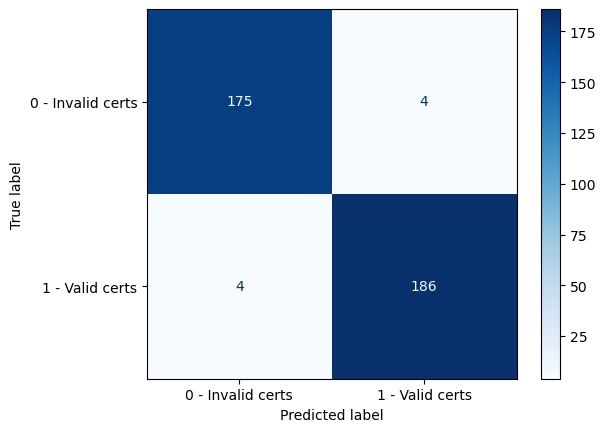

In [454]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0 - Invalid certs", "1 - Valid certs"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Plotted ROC Curve

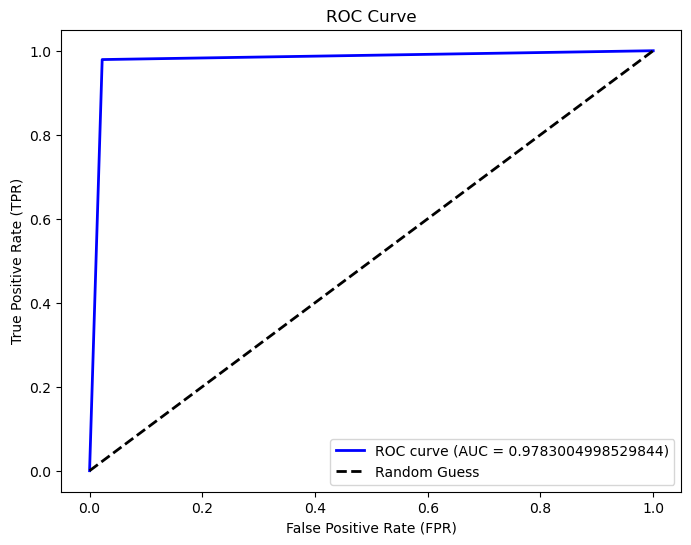

In [455]:
FPR, TPR, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(FPR, TPR)

plt.figure(figsize=(8, 6))
plt.plot(FPR, TPR, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title("ROC Curve")

plt.legend()
plt.show()

In [456]:
roc_auc

0.9783004998529844

### Plotted Percision-Recall Curve

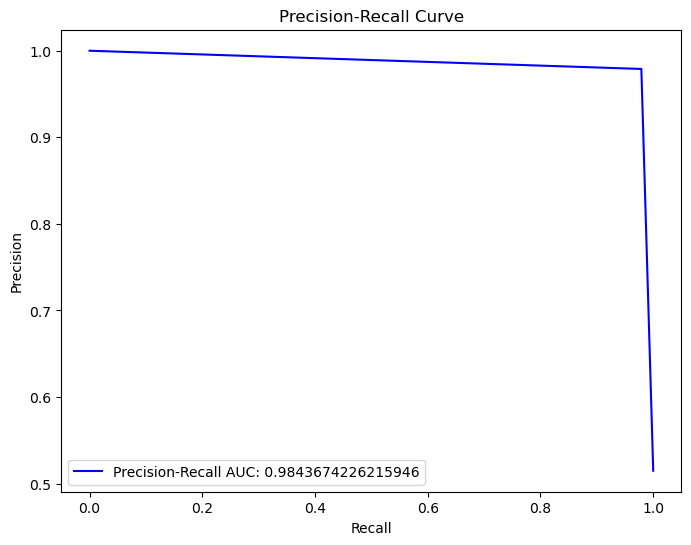

In [463]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall AUC: {pr_auc}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [458]:
pr_auc

0.9843674226215946

### Plotted Feature Importance

In [459]:
feature_importances = rf.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': feature_importances
    }
)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

In [460]:
feature_importance_df

,Feature,Importance
8,Cert Hash,0.000000
9,Short Key,0.000000
11,Weak Sig,0.000018
10,Expired,0.010606
5,SAN,0.026866
3,PK Algorithm,0.029704
4,PK Size,0.059102
7,Sig Algorithm,0.081703
2,ExpDate,0.114778
1,StartDate,0.143672


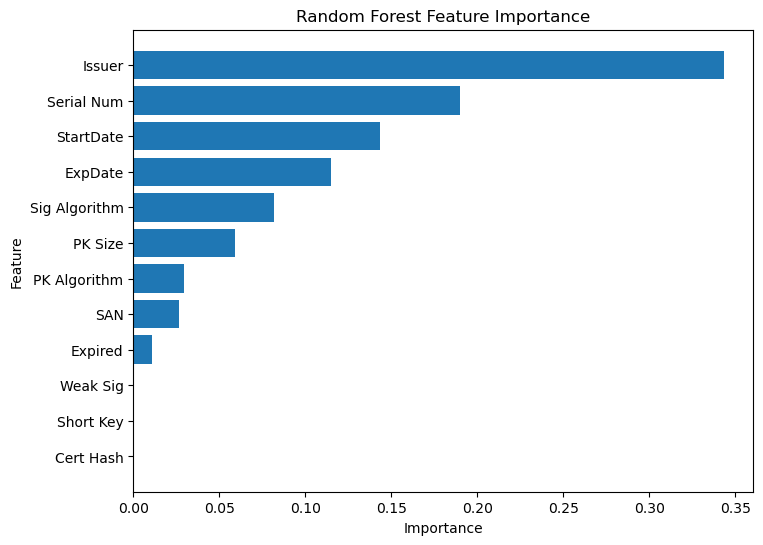

In [461]:
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()